In [1]:
from pathlib import Path

import numpy as np
import tensorflow as tf
import keras_tuner as kt
from matplotlib import pyplot as plt

In [2]:
DATASET_BASE_DIR = Path("../MNIST-ObjectDetection/data/mnist_detection")

In [3]:
dataset_train = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_BASE_DIR / "train" / "classification",
    label_mode="categorical",
    color_mode="grayscale",
    image_size=(28, 28),
    shuffle=True,
    seed=42,
)
dataset_test = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_BASE_DIR / "test" / "classification",
    label_mode="categorical",
    color_mode="grayscale",
    image_size=(28, 28),
    shuffle=True,
    seed=42,
)
dataset_validation = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_BASE_DIR / "validation" / "classification",
    label_mode="categorical",
    color_mode="grayscale",
    image_size=(28, 28),
    shuffle=True,
    seed=42,
)

Found 125 files belonging to 10 classes.
Found 130 files belonging to 10 classes.
Found 116 files belonging to 10 classes.


In [4]:
dataset_train = dataset_train.map(lambda x, y: (x / 255., y))
dataset_test = dataset_test.map(lambda x, y: (x / 255., y))
dataset_validation = dataset_validation.map(lambda x, y: (x / 255., y))

0.0 1.0
(32, 28, 28, 1)


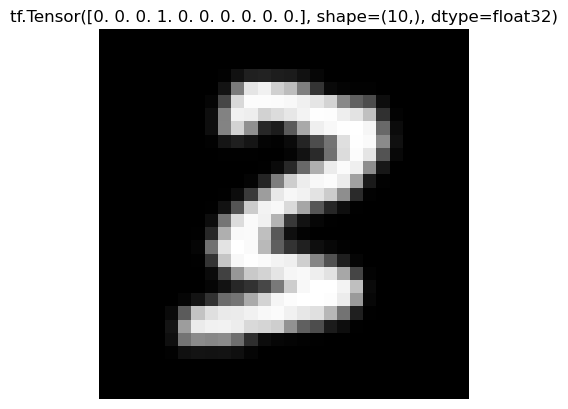

In [5]:
# visualize just in case
for x, y in dataset_train:
    x = x.numpy()
    plt.axis(False)
    plt.title(y[0])
    plt.imshow(x[0], cmap="gray")
    print(x.min(), x.max())
    print(x.shape)
    break

In [6]:
def model_builder(hp: kt.HyperParameters):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(28, 28, 1)))

    usebatchnorm = hp.Boolean("usebatchnorm")
    dropout = hp.Float("dropout", .1, .4, .1)

    conv1filters = hp.Int("conv1filters", 32, 128, 32)
    conv1regularizer = hp.Boolean("conv1regularizer")
    conv1regularizer_str = "l2" if conv1regularizer else None
    model.add(tf.keras.layers.Conv2D(conv1filters, 3, activation="relu", kernel_regularizer=conv1regularizer_str, padding="same"))
    if usebatchnorm:
        model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D())
    model.add(tf.keras.layers.Dropout(dropout))

    useconv2 = hp.Boolean("useconv2")
    conv2filters = hp.Int("conv2filters", 32, 256, 32)
    conv2regularizer = hp.Boolean("conv2regularizer")
    if useconv2:
        conv2regularizer_str = "l2" if conv2regularizer else None
        model.add(tf.keras.layers.Conv2D(conv2filters, 3, activation="relu", kernel_regularizer=conv2regularizer_str, padding="same"))
    if usebatchnorm:
        model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D())
    model.add(tf.keras.layers.Dropout(dropout))

    useconv3 = hp.Boolean("useconv3")
    conv3filters = hp.Int("conv3filters", 32, 256, 32)
    conv3regularizer = hp.Boolean("conv3regularizer")
    if useconv3:
        conv3regularizer_str = "l2" if conv3regularizer else None
        model.add(tf.keras.layers.Conv2D(conv3filters, 3, activation="relu", kernel_regularizer=conv3regularizer_str, padding="same"))
    if usebatchnorm:
        model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D())
    model.add(tf.keras.layers.Dropout(dropout))

    model.add(tf.keras.layers.Flatten())

    units = hp.Int("units", 16, 256, 16)
    model.add(tf.keras.layers.Dense(units, activation="relu"))

    model.add(tf.keras.layers.Dense(10, activation="softmax"))

    lr = hp.Float("lr", 1e-3, .1, 5e-3)
    model.compile(tf.keras.optimizers.Adam(lr), "categorical_crossentropy", ["accuracy"])
    return model

In [7]:
tuner = kt.Hyperband(model_builder, objective="val_accuracy", max_epochs=200, directory="tuner", project_name="classifier", overwrite=True)

In [8]:
tuner.search(dataset_train, epochs=1000, validation_data=dataset_validation, callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=10)])

Trial 254 Complete [00h 00m 04s]
val_accuracy: 0.16379310190677643

Best val_accuracy So Far: 0.9137930870056152
Total elapsed time: 00h 14m 49s


In [9]:
best_hps = tuner.get_best_hyperparameters()[0]
model = tuner.hypermodel.build(best_hps)

In [10]:
best_hps.values

{'usebatchnorm': False,
 'dropout': 0.4,
 'conv1filters': 128,
 'conv1regularizer': True,
 'useconv2': True,
 'conv2filters': 224,
 'conv2regularizer': False,
 'useconv3': False,
 'conv3filters': 192,
 'conv3regularizer': True,
 'units': 48,
 'lr': 0.011,
 'tuner/epochs': 200,
 'tuner/initial_epoch': 67,
 'tuner/bracket': 1,
 'tuner/round': 1,
 'tuner/trial_id': '0236'}

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       1280      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 14, 14, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 224)       258272    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 7, 7, 224)        0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 7, 7, 224)        

In [12]:
callbacks = [
    tf.keras.callbacks.CSVLogger("classifier.csv"),
    tf.keras.callbacks.TerminateOnNaN(),
    tf.keras.callbacks.TensorBoard("classifier/"),
    tf.keras.callbacks.ModelCheckpoint("classifier.keras", save_best_only=True, monitor="val_accuracy"),
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=100),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", patience=10),
]

In [13]:
history = model.fit(dataset_train, epochs=1000, callbacks=callbacks, validation_data=dataset_validation, batch_size=16)

Epoch 1/1000


4/4 [==============================] - 2s 208ms/step - loss: 2.6534 - accuracy: 0.1040 - val_loss: 2.3190 - val_accuracy: 0.1466 - lr: 0.0110
Epoch 2/1000
4/4 [==============================] - 1s 101ms/step - loss: 2.3193 - accuracy: 0.1520 - val_loss: 2.3161 - val_accuracy: 0.1724 - lr: 0.0110
Epoch 3/1000
4/4 [==============================] - 0s 83ms/step - loss: 2.2785 - accuracy: 0.1680 - val_loss: 2.2535 - val_accuracy: 0.2931 - lr: 0.0110
Epoch 4/1000
4/4 [==============================] - 0s 59ms/step - loss: 2.1150 - accuracy: 0.2880 - val_loss: 2.0330 - val_accuracy: 0.3534 - lr: 0.0110
Epoch 5/1000
4/4 [==============================] - 0s 62ms/step - loss: 2.0053 - accuracy: 0.2800 - val_loss: 1.9549 - val_accuracy: 0.4138 - lr: 0.0110
Epoch 6/1000
4/4 [==============================] - 0s 44ms/step - loss: 1.9037 - accuracy: 0.3680 - val_loss: 1.8817 - val_accuracy: 0.3966 - lr: 0.0110
Epoch 7/1000
4/4 [==============================] - 0s 59ms/step - loss: 1.5598 - accur

In [14]:
best_model = tf.keras.models.load_model("classifier.keras")

In [15]:
best_model.evaluate(dataset_test)

5/5 [==============================] - 0s 45ms/step - loss: 0.5086 - accuracy: 0.8538


[0.5085849761962891, 0.8538461327552795]

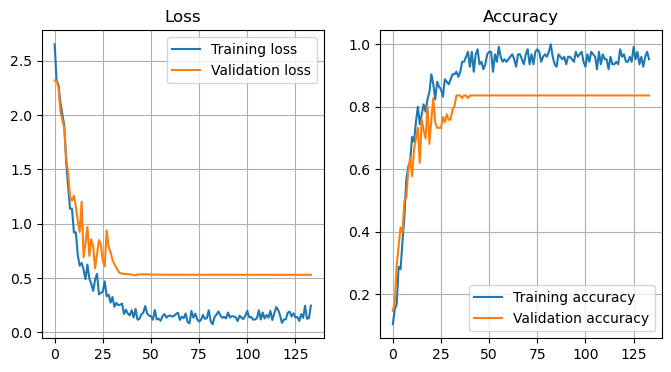

In [16]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.grid()
plt.plot(loss)
plt.plot(val_loss)
plt.title("Loss")
plt.legend(["Training loss", "Validation loss"])

plt.subplot(1, 2, 2)
plt.grid()
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title("Accuracy")
plt.legend(["Training accuracy", "Validation accuracy"])
plt.savefig("lossaccuracy.png")